# 06 kernel-based AS

In order to extend the methodology to cases which don't have an Active Subspace, we can consider searching for a kernel-based Active Subspace. 

As is common practice in Machine Learning to project the inputs from $\chi\subset\mathbb{R}^{m}$ to a Reproducing Kernel Hilbert Space (RKHS), the inputs are immersed with a feature space map $\phi$ into a supposedly infinite-dimensional Hilbert space $\phi(\chi)\subset\mathbb{H}$. Then the model function of interest factorizes over this feature map $\phi$ and a new model function $\bar{f}$ with domain the feature space

$$
f:\chi\subset\mathbb{R}^{m}\rightarrow\mathbb{R},\quad \phi:\chi\subset\mathbb{R}^{m}\rightarrow\mathbb{H}\approx\mathbb{R}^{D},\quad\bar{f}:\phi(\chi)\subset\mathbb{H}\rightarrow\mathbb{R}\\
$$

$$
f = \bar{f}\circ\phi
$$

the RKHS $\mathbb{H}$ is approximated with a discrete feature space $\mathbb{R}^{D}$.

Searching for a kernel-based Active Subspace then reduces to finding an Active Subspace of the new model function $\bar{f}:\chi\subset\mathbb{H}\rightarrow\mathbb{R}$. In this tutorial we will consider the design of one-dimensional response functions with Gaussian process regression. A scheme of the procedure is shown below

![KAS](06_KAS/draft.svg)

To look more in to the details of the procedure see [Kernel-based Active Subspaces with application to CFD parametric problems using Discontinuous Galerkin method](https://arxiv.org/abs/2008.12083). The feature map we adopt was introduced in [Gaussian Process Modeling and
Supervised Dimensionality
Reduction Algorithms via Stiefel
Manifold Learning](https://tspace.library.utoronto.ca/bitstream/1807/91625/3/Palaci-Olgun_Marc_201811_MAS_thesis.pdf).

The tutorial requires [GPy](https://github.com/SheffieldML/GPy) for the design of response surfaces (used inside the tuning procedure) and [GPyOpt](https://github.com/SheffieldML/GPyOpt) for the optimization of the parameters of the feature map that will be introduced later.

In [2]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt
from functools import partial
import GPy

from athena.active import ActiveSubspaces
from athena.kas import KernelActiveSubspaces
from athena.feature_map import FeatureMap, rff_map, rff_jac
from athena.projection_factory import ProjectionFactory
from athena.utils import Normalizer, CrossValidation, average_rrmse

from data.numpy_functions import radial

In [3]:
np.random.seed(42)

# global parameters
n_samples = 800  # this is the number of data points to use for the tuning of kas
N = 500 # this is the number of test samples to use
input_dim = 2

# set the dimension of the discrete feature space (D in the introduction)
n_features = 1000

In [4]:
def sample_in_out(input_dim, n_samples):
    #input ranges
    lb = np.array(-3 * np.ones(input_dim))
    ub = np.array(3 * np.ones(input_dim))

    #input normalization
    XX = np.random.uniform(lb, ub, (n_samples, input_dim))

    nor = Normalizer(lb, ub)
    x = nor.fit_transform(XX)

    #output values (f) and gradients (df)
    func = partial(radial, normalizer=nor, generatrix=lambda x: np.cos(x))
    f = func(x)
    df = egrad(func)(x)
    return x, f, df

Some samples (xx, f, df) will be used for the tuning phase of the kernel-based active subspaces proceure, the remaining (y, t, dt) represents the test dataset.

In [5]:
xx, f, df = sample_in_out(input_dim, n_samples)
y, t, dt = sample_in_out(input_dim, N)

### Active subspaces

An active subspace is searched for, but due to the radial symmetry of the model there is no preferred direction of variation. The same result could be obtained changing the generatrix of the model. These are cases where linear active subspaces are not present and other methods should be taken in consideration.

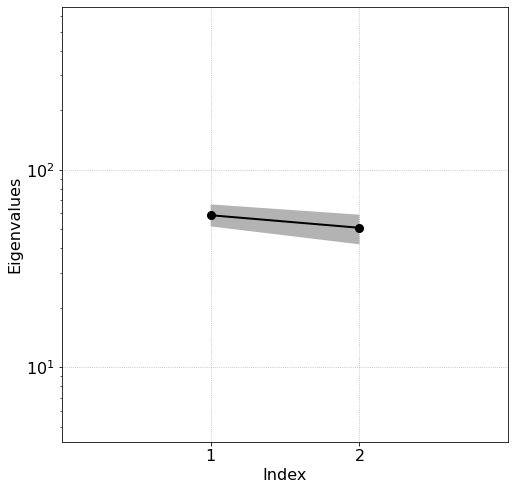

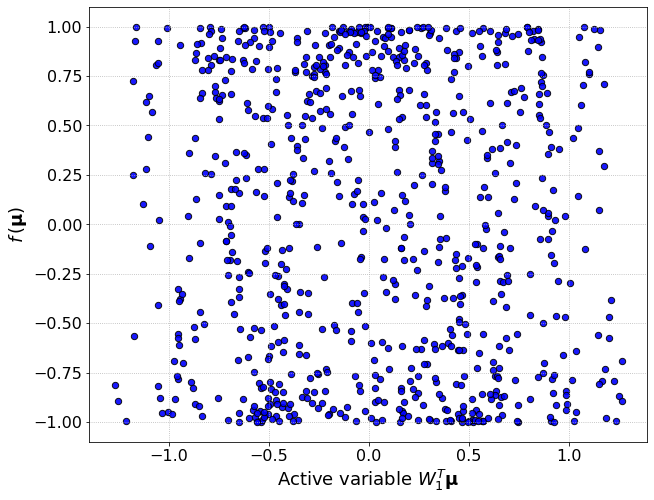

In [6]:
#AS
ss = ActiveSubspaces()
ss.compute(gradients=dt, outputs=t, inputs=y, method='exact')
ss.partition(1)
ss.plot_eigenvalues()
ss.plot_sufficient_summary(y, t)

### Kernel-based active subspaces

Define the feature map and pass it to the KernelActiveSubspaces class. The feature map is defined as

$$
\phi(\mathbf{x})=\sqrt{\frac{2}{D}}\,\sigma_f\,\cos(W\mathbf{x}+\mathbf{b}),\\
\cos(W\mathbf{x}+\mathbf{b}):=\frac{1}{\sqrt{D}}(\cos(W[1, :] \cdot \mathbf{x} +b_1),\dots, \cos(W[D, :] \cdot \mathbf{x} +b_D))^T
$$

where $\sigma_f$ cooresponds to the empirical
variance of the model, $W\in \mathcal{M}(D\times m,\mathbb{R})$ is the
projection matrix whose rows are sampled from a probability
distribution on $\mathbb{R}^m$ and $\mathbf{b}\in \mathbb{R}^D$ is a bias term whose components are
sampled independently and uniformly in the interval $[0, 2\pi]$.

In [ ]:
# number of parameters of the spectral distribution associated to the feature map
# this is the number of parameters to tune after
n_params = 1

# sample the bias term
b = np.random.uniform(0, 2 * np.pi, n_features)
#np.save("06_KAS/bias", b)

The list of implemented distributions to chose from is the following, the number of parameters to tune for each distribution is reported in the [documentation](https://mathlab.github.io/ATHENA/projection_factory.html).

In [10]:
ProjectionFactory.projections    

['beta',
 'cauchy',
 'dirichlet',
 'laplace',
 'multivariate_normal',
 'normal',
 'uniform']

In [7]:
# define the feature map
fm = FeatureMap(distr='laplace',
                bias=b,
                input_dim=input_dim,
                n_features=n_features,
                params=np.zeros(n_params),
                sigma_f=f.var())

# instantiate a KernelActiveSubspaces object with associated feature map 
kss = KernelActiveSubspaces(feature_map=fm)

The feature map hyperparameters are to be tuned. Different methods are available, see the [documentation](https://mathlab.github.io/ATHENA/feature_map.html). In this tutorial we will use [Bayesian stochastic optimization](https://github.com/SheffieldML/GPyOpt).

In [8]:
# number of folds for the cross-validation algorithm
folds = 3

# Skip if bias and projection matrix are loaded
csv = CrossValidation(inputs=xx,
                      outputs=f.reshape(-1, 1),
                      gradients=df.reshape(n_samples, 1, input_dim),
                      folds=folds,
                      subspace=kss,
                      n_features=n_features)
best = fm.tune_pr_matrix(func=average_rrmse,
                  bounds=[slice(-2, 1, 0.2) for i in range(n_params)],
                  args=(csv, ),
                  method='bso',
                  maxiter=20,
                  save_file=True)

print("The lowest rrmse is {}%".format(best[0]))

################################################################################
params [0.32750886] mean 0.988049312561739, std 0.017076038292701247
################################################################################
params [5.17921627] mean 0.987526807224763, std 0.006314935182773818
################################################################################
params [0.65683763] mean 0.5306431394153356, std 0.049679141950836246
params [0.65683763] mean 0.5096165207302755, std 0.050087286887713925
params [0.65683763] mean 0.6945833754394365, std 0.2187120504035234
params [0.65683763] mean 0.625519432649402, std 0.2735457063654906
params [0.65683763] mean 0.8391804040414641, std 0.2283871008338183
################################################################################
params [0.04335835] mean 0.992538070569899, std 0.01075450399827837
################################################################################
params [0.45669332] mean 0.7692465164080001, s

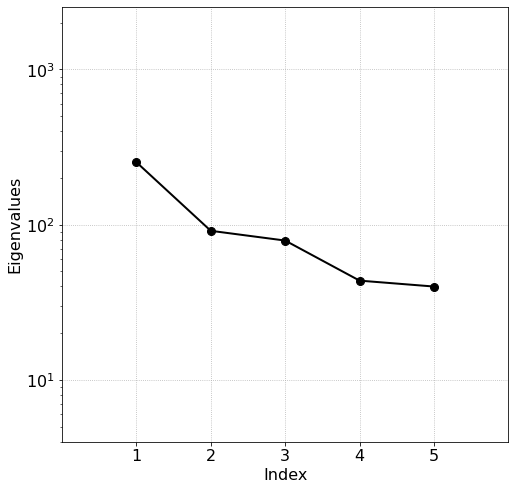

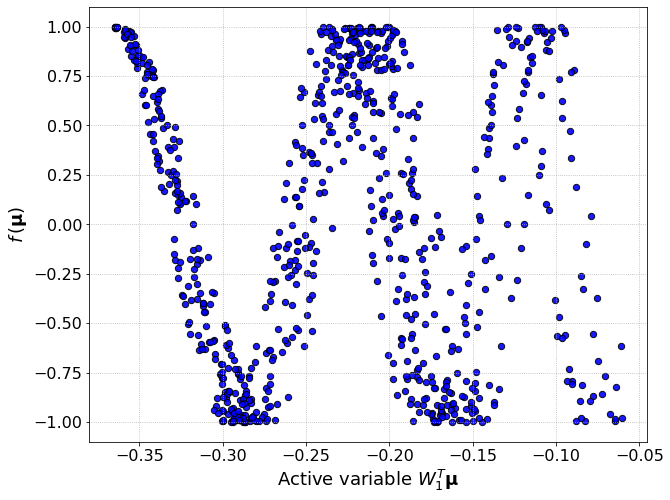

In [11]:
W = np.load("06_KAS/opt_pr_matrix.npy", allow_pickle=True)
b = np.load("06_KAS/bias.npy", allow_pickle=True)
fm._pr_matrix = W
fm.bias = b
kss.compute(gradients=dt.reshape(N, 1, input_dim),
            outputs=t,
            inputs=y,
            method='exact',
            n_features=n_features)

kss.partition(1)
kss.plot_eigenvalues(n_evals=5)
kss.plot_sufficient_summary(xx, f)